# Worked Example of Bi-level Optimization

We present a worked example for bi-level optimimzation problems of the following form:

$$
\begin{array}{rl}
    \text{minimize} & \frac{1}{2} \|y - y^\text{target}\|^2 \\
    \text{subject to} & y \in \left\{ \begin{array}{rl}
        \text{argmin}_u & f(x, u)\\
        \text{subject to} & h(x, u) = 0
        \end{array} \right\}
\end{array}
$$

where the lower-level problem defines an equality constrained declarative node and the upper-level
problem tries to learn the input $x$ such that the output of the declarative node matches some target
value $y^\text{target}$ (or to get close to it in a least-squares sense).

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

import sys
sys.path.append("../")
from ddn.basic.node import *
from ddn.basic.sample_nodes import LinFcnOnUnitCircle
from ddn.basic.robust_nodes import RobustAverage

We begin by implementing a simple gradient descent procedure that computes

$$
\text{D} J(y(x)) = \text{D}_Y J(y) \text{D} y(x)
$$

where $J(y) = \frac{1}{2} \|y(x) - y^\text{target}\|^2$ and $\text{D}y$ is computed via implicity differentiation. Here $\text{D} J(y(x))$ is the derivative of $J$ with respect to $x$ (the independent variable) and $\text{D}_Y J(y)$ is the partial derivative of $J$ with respect to $y$.

In [3]:
def simpleGradientDescent(node, y_target, step_size=1.0e-3, tol=1.0e-6, max_iters=1000, x_init=None, verbose=False):
    """
    An example of gradient descent for a simple bi-level optimization problem of the form:
        minimize_{x} 0.5 * \|y - y_target\|^2
        subject to y = argmin_u f(x, u) s.t. h(x, u) = 0

    Returns the solution x found and learning curve (objective function J per iteration).
    """
    assert y_target.shape[0] == node.dim_y
    x = x_init.copy() if x_init is not None else np.zeros((node.dim_x,))

    J = lambda y : 0.5 * np.sum(np.square(y - y_target))
    dJdy = lambda y : y - y_target

    history = []
    for i in range(max_iters):
        y, _ = node.solve(x)
        history.append(J(y))
        if verbose: print("{:5d}: {}".format(i, history[-1]))
        if (len(history) > 2) and (history[-2] - history[-1]) < tol:
            break
        dJdx = np.dot(dJdy(y), node.gradient(x, y))
        x -= step_size * dJdx

    return x, history

We can also implement a more sophisticated optimizer using L-BFGS:

In [4]:
def lbfgs(node, y_target, max_iters=100, x_init=None, verbose=True):
    """
    Example of using scipy.optimize to solve the problem via L-BFGS.
    """
    assert y_target.shape[0] == node.dim_y
    x_start = x_init.copy() if x_init is not None else np.zeros((node.dim_x,))
    
    def J(x):
        y, _ = node.solve(x)
        return 0.5 * np.sum(np.square(y - y_target))
    def dJdx(x):
        y, _ = node.solve(x)
        return np.dot(y - y_target, node.gradient(x, y)).reshape((node.dim_x,))

    history = [J(x_start)]
    def callback(xk):
        history.append(J(xk))

    opts = {'maxiter': max_iters, 'disp': verbose}
    result = opt.minimize(J, x_start, args=(), method='L-BFGS-B', jac=dJdx, options=opts, callback=callback)
    return result.x, history

Let's test the code by trying to solve a simple bi-level optimization problem.

$$
\begin{array}{rl}
    \text{minimize} & \frac{1}{2} \|y + (1, 1)\|^2 \\
    \text{subject to} & y \in \left\{ \begin{array}{rl}
        \text{argmin}_u & (1, x)^T u\\
        \text{subject to} & \|u\|^2 = 1
        \end{array} \right\}
\end{array}
$$

By inspection, the solution to this problem is $x = 1$, which gives $y = -\left(\frac{1}{\sqrt{2}}, \frac{1}{\sqrt{2}}\right)$. 

C:\Anaconda3\lib\site-packages\autograd\tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Gradient descent to give x = [0.99147837] gives y = [-0.71012602 -0.70407459]
L-BFGS finds x = [1.] to give y = [-0.70710678 -0.70710678]


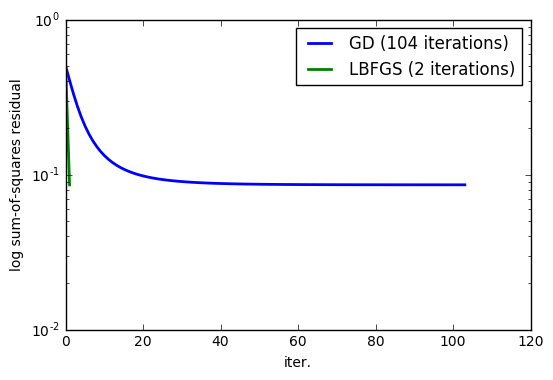

In [5]:
node = LinFcnOnUnitCircle()
y_target = np.array([-1.0, -1.0])

x, history_gd = simpleGradientDescent(node, y_target, step_size=0.1)
y_star, _ = node.solve(x)
print("Gradient descent to give x = {} gives y = {}".format(x, y_star))

x, history_bfgs = lbfgs(node, y_target)
y_star, _ = node.solve(x)
print("L-BFGS finds x = {} to give y = {}".format(x, y_star))

plt.figure()
plt.semilogy(history_gd, lw=2)
plt.semilogy(history_bfgs, lw=2)
plt.xlabel("iter."); plt.ylabel("log sum-of-squares residual")
plt.legend(["GD ({} iterations)".format(len(history_gd)), "LBFGS ({} iterations)".format(len(history_bfgs))])
plt.show()

We now consider a more sophisticated example where we wish to optimize points to achieve a robust average of zero. We use the Huber penalty to estimate the robust average,

$$
\begin{array}{rl}
    \text{minimize} & \frac{1}{2} y^2 \\
    \text{subject to} & y \in \text{argmin}_u \sum_{i=1}^{n} \phi^\text{huber}(u - x_i; \alpha = 1)
\end{array}
$$

where

$$
\phi^\text{huber}(z, \alpha) = \begin{cases}
\frac{1}{2} z^2 & \text{if $|z| \leq \alpha$} \\
\alpha|z| - \frac{1}{2}\alpha^2 & \text{otherwise}
\end{cases}
$$

We start with randomly generated $n$-dimensional input, $x$.

Initial x = [7.26816534e-02 5.79561516e-01 8.44739706e+01 9.46741331e-01
 1.01436597e-01 8.11365367e-01 7.69945133e-01 6.02706166e-01
 1.54288198e-01 6.92763378e-01]
Mean of intial x is 8.920545992813004
Robust mean of initial x is [0.63683215]

Gradient descent to give x = [-5.60217477e-01 -5.33376137e-02  8.44739706e+01  3.13842201e-01
 -5.31462533e-01  1.78466237e-01  1.37046003e-01 -3.01929640e-02
 -4.78610932e-01  5.98642481e-02]
Mean of x is 8.350936775741875
Robust mean of x is [0.00393302]

L-BFGS finds x = [-5.64150495e-01 -5.72706325e-02  8.44739706e+01  3.09909182e-01
 -5.35395552e-01  1.74533218e-01  1.33112984e-01 -3.41259829e-02
 -4.82543951e-01  5.59312292e-02]
Mean of x is 8.347397058775414
Robust mean of x is [6.9388939e-17]


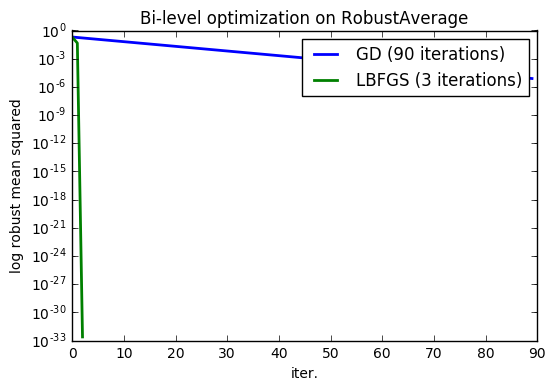

In [6]:
n = 10 # number of input points
node = RobustAverage(n, penalty='huber', alpha=1.0)
y_target = np.array([0.0])
x_init = np.random.rand(n)

# add an outlier
x_init[np.random.randint(len(x_init))] += 100.0 * np.random.rand(1)

# show starting average
y_init, _ = node.solve(x_init)
print("Initial x = {}".format(x_init))
print("Mean of intial x is {}".format(np.mean(x_init)))
print("Robust mean of initial x is {}".format(y_init))
print()

# solve using gradient descent
x_gd, history_gd = simpleGradientDescent(node, y_target, step_size=0.5, x_init=x_init)
y_star, _ = node.solve(x_gd)
print("Gradient descent to give x = {}".format(x_gd))
print("Mean of x is {}".format(np.mean(x_gd)))
print("Robust mean of x is {}".format(y_star))
print()

# solver using L-BFGS
x_bfgs, history_bfgs = lbfgs(node, y_target, x_init=x_init)
y_star, _ = node.solve(x_bfgs)
print("L-BFGS finds x = {}".format(x_bfgs))
print("Mean of x is {}".format(np.mean(x_bfgs)))
print("Robust mean of x is {}".format(y_star))

# plot results
plt.figure()
plt.semilogy(history_gd, lw=2)
plt.semilogy(history_bfgs, lw=2)
plt.xlabel("iter."); plt.ylabel("log robust mean squared")
plt.title("Bi-level optimization on {}".format(type(node).__name__))
plt.legend(["GD ({} iterations)".format(len(history_gd)), "LBFGS ({} iterations)".format(len(history_bfgs))])
plt.show()